In [ ]:
!pip install transformers wandb

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import wandb

wandb.login()

True

In [ ]:
sweep_config = {'method': 'grid'}

In [ ]:
metric = {'name': 'val_acc','goal': 'maximize'}
sweep_config['metric'] = metric

In [ ]:
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd',"AdamW"]
        },
    'learning_rate': {
        'values': [5e-3, 1e-4, 3e-5, 6e-5, 1e-5]
        },
    'epochs': {
        'values': [2,4,6,8]},
}

sweep_config['parameters'] = parameters_dict

In [ ]:
import pprint

pprint.pprint(sweep_config)

{'method': 'grid',
 'metric': {'goal': 'maximize', 'name': 'val_acc'},
 'parameters': {'epochs': {'values': [2, 4, 6, 8]},
                'learning_rate': {'values': [0.005,
                                             0.0001,
                                             3e-05,
                                             6e-05,
                                             1e-05]},
                'optimizer': {'values': ['adam', 'sgd', 'AdamW']}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="pytorch-sweep")

Create sweep with ID: q6ui06h0
Sweep URL: https://wandb.ai/vveizhang/pytorch-sweep/sweeps/q6ui06h0


In [ ]:
bert_model = BertModel.from_pretrained("bert-base-cased")
class SentimentClassifier(nn.Module):
  def __init__(self,n_classes,dropout):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(dropout)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    returned = self.bert(
    input_ids=input_ids,
    attention_mask=attention_mask
    )
    pooled_output = returned["pooler_output"]
    output = self.drop(pooled_output)
    return self.out(output)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
df = pd.read_csv("/content/df.csv",encoding="ISO-8859-1")
df = df[["text","label"]]
df.head()

,text,label
0,"They buy bitcoin with any dollars you have, an...",0
1,why mine bitcoin when I could minecraft.,0
2,What are you talking about? Bitcoin is backed ...,0
3,Bitcoin is worthless and no one who accepts it...,0
4,Awesome. Fuck bitcoin.,0


In [ ]:
df.label.value_counts()

2    1485
1     945
0     681
Name: label, dtype: int64

In [ ]:
df.shape

(3111, 2)

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


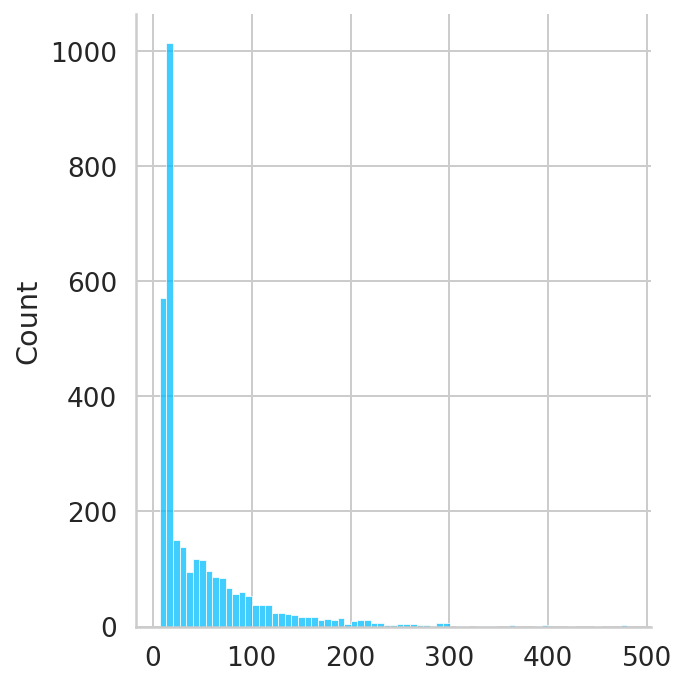

In [ ]:
token_lens = []
for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
sns.displot(token_lens)

In [ ]:
MAX_LEN = 300
class redditDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      truncation=True,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      #pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(
  df,
  test_size=0.2,
  random_state=RANDOM_SEED)
print(len(df_train))
print(len(df_test))

2488
623


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = redditDataset(
    reviews=df.text.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
#val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
def train(config=None):
  with wandb.init(config=config):
    config = wandb.config

    EPOCHS = config.epochs
    model = SentimentClassifier(3,config.dropout).to(device)
    optimizer = build_optimizer(model,config.optimizer,config.learning_rate)
    total_steps = len(train_data_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=0,
      num_training_steps=total_steps
    )
    loss_fn = nn.CrossEntropyLoss().to(device)
    history = defaultdict(list)
    best_accuracy = 0
    for epoch in range(EPOCHS):
      print(f'Epoch {epoch + 1}/{EPOCHS}')
      print('-' * 10)
      train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
      )
      print(f'Train loss {train_loss} accuracy {train_acc}')
      val_acc, val_loss = eval_model(
        model,
        test_data_loader,
        loss_fn,
        device,
        len(df_test)
      )
      print(f'Val   loss {val_loss} accuracy {val_acc}')
      print()
      history['train_acc'].append(train_acc)
      history['train_loss'].append(train_loss)
      history['val_acc'].append(val_acc)
      history['val_loss'].append(val_loss)
      wandb.log({
        'epoch': epoch, 
        'train_acc': train_acc,
        'train_loss': train_loss, 
        'val_acc': val_acc, 
        'val_loss': val_loss
      })
      if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 300])
torch.Size([16, 300])
torch.Size([16])


In [ ]:
def build_optimizer(model, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = optim.Adam(model.parameters(),lr=learning_rate)
    elif optimizer == "AdamW":
        optimizer = optim.AdamW(model.parameters(),lr=learning_rate)
    return optimizer

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: yo5r38wn with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 2
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/2
----------
Train loss 1.0481460384833508 accuracy 0.4533762057877814
Val   loss 1.000726621884566 accuracy 0.47351524879614765

Epoch 2/2
----------
Train loss 0.9713790451104825 accuracy 0.5329581993569131
Val   loss 0.9630571160560999 accuracy 0.521669341894061



epoch,▁█
train_acc,▁█
train_loss,█▁
val_acc,▁█
val_loss,█▁
epoch,1
train_acc,0.53296
train_loss,0.97138
val_acc,0.52167
val_loss,0.96306


wandb: Agent Starting Run: 6bym2mmm with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 2
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: AdamW
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/2
----------
Train loss 0.3863338894951038 accuracy 0.8818327974276527
Val   loss 0.3031721158096424 accuracy 0.9229534510433387

Epoch 2/2
----------
Train loss 0.23066191479730874 accuracy 0.9481511254019293
Val   loss 0.30486278744557727 accuracy 0.92776886035313



epoch,▁█
train_acc,▁█
train_loss,█▁
val_acc,▁█
val_loss,▁█
epoch,1
train_acc,0.94815
train_loss,0.23066
val_acc,0.92777
val_loss,0.30486


wandb: Agent Starting Run: ta3cxhuh with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 2
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/2
----------
Train loss 0.3944344210605591 accuracy 0.8605305466237942
Val   loss 0.24930811448930165 accuracy 0.9325842696629213

Epoch 2/2
----------
Train loss 0.18774836043564555 accuracy 0.9553858520900321
Val   loss 0.2570946884747499 accuracy 0.9406099518459069



epoch,▁█
train_acc,▁█
train_loss,█▁
val_acc,▁█
val_loss,▁█
epoch,1
train_acc,0.95539
train_loss,0.18775
val_acc,0.94061
val_loss,0.25709


wandb: Agent Starting Run: cqihsury with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 2
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/2
----------
Train loss 1.144070104910777 accuracy 0.29059485530546625
Val   loss 1.0728539106173394 accuracy 0.5088282504012841

Epoch 2/2
----------
Train loss 1.06881929284487 accuracy 0.44011254019292606
Val   loss 1.0503964592248967 accuracy 0.4767255216693419



epoch,▁█
train_acc,▁█
train_loss,█▁
val_acc,█▁
val_loss,█▁
epoch,1
train_acc,0.44011
train_loss,1.06882
val_acc,0.47673
val_loss,1.0504


wandb: Agent Starting Run: ziggidrn with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 2
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: AdamW
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/2
----------
Train loss 0.3862658373486155 accuracy 0.8745980707395499
Val   loss 0.22770685855394754 accuracy 0.942215088282504

Epoch 2/2
----------
Train loss 0.19703257930441162 accuracy 0.944935691318328
Val   loss 0.21310476698458958 accuracy 0.9486356340288924



epoch,▁█
train_acc,▁█
train_loss,█▁
val_acc,▁█
val_loss,█▁
epoch,1
train_acc,0.94494
train_loss,0.19703
val_acc,0.94864
val_loss,0.2131


wandb: Agent Starting Run: agkoqswh with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 2
wandb: 	learning_rate: 6e-05
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/2
----------
Train loss 0.3819270610021284 accuracy 0.8786173633440514
Val   loss 0.28430843692368424 accuracy 0.9261637239165329

Epoch 2/2
----------
Train loss 0.19864364231650072 accuracy 0.9497588424437299
Val   loss 0.2716163790378815 accuracy 0.92776886035313



epoch,▁█
train_acc,▁█
train_loss,█▁
val_acc,▁█
val_loss,█▁
epoch,1
train_acc,0.94976
train_loss,0.19864
val_acc,0.92777
val_loss,0.27162


wandb: Agent Starting Run: vmb8pelo with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 2
wandb: 	learning_rate: 6e-05
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/2
----------
Train loss 1.1802113468830402 accuracy 0.2982315112540193
Val   loss 1.0630264587891407 accuracy 0.5489566613162119

Epoch 2/2
----------
Train loss 1.040662911075812 accuracy 0.4903536977491961
Val   loss 1.0396020198479676 accuracy 0.47351524879614765



epoch,▁█
train_acc,▁█
train_loss,█▁
val_acc,█▁
val_loss,█▁
epoch,1
train_acc,0.49035
train_loss,1.04066
val_acc,0.47352
val_loss,1.0396


wandb: Agent Starting Run: p8ikxcdm with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 2
wandb: 	learning_rate: 6e-05
wandb: 	optimizer: AdamW
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/2
----------
Train loss 0.3970756352138825 accuracy 0.877411575562701
Val   loss 0.3467364028000679 accuracy 0.8956661316211878

Epoch 2/2
----------
Train loss 0.22266466783073086 accuracy 0.9405144694533762
Val   loss 0.24321706604976684 accuracy 0.9341894060995185



epoch,▁█
train_acc,▁█
train_loss,█▁
val_acc,▁█
val_loss,█▁
epoch,1
train_acc,0.94051
train_loss,0.22266
val_acc,0.93419
val_loss,0.24322


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m03jnfac with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 2
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/2
----------
Train loss 0.5562150700447651 accuracy 0.7938102893890675
Val   loss 0.3380567235633349 accuracy 0.9101123595505618

Epoch 2/2
----------
Train loss 0.27113254096072453 accuracy 0.927652733118971
Val   loss 0.2932517063827851 accuracy 0.9229534510433387



epoch,▁█
train_acc,▁█
train_loss,█▁
val_acc,▁█
val_loss,█▁
epoch,1
train_acc,0.92765
train_loss,0.27113
val_acc,0.92295
val_loss,0.29325


wandb: Agent Starting Run: uf1f8ycn with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 2
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/2
----------
Train loss 1.0908168924924655 accuracy 0.3946945337620579
Val   loss 1.0798362890879314 accuracy 0.45906902086677365

Epoch 2/2
----------
Train loss 1.0800759929877062 accuracy 0.43287781350482313
Val   loss 1.0752442570833058 accuracy 0.463884430176565



epoch,▁█
train_acc,▁█
train_loss,█▁
val_acc,▁█
val_loss,█▁
epoch,1
train_acc,0.43288
train_loss,1.08008
val_acc,0.46388
val_loss,1.07524


wandb: Agent Starting Run: o0ozwe5u with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 2
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: AdamW
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/2
----------
Train loss 0.5640962270972056 accuracy 0.7986334405144695
Val   loss 0.34303032922057003 accuracy 0.9197431781701445

Epoch 2/2
----------
Train loss 0.2779959060060672 accuracy 0.9280546623794212
Val   loss 0.29264366173018247 accuracy 0.9245585874799358



epoch,▁█
train_acc,▁█
train_loss,█▁
val_acc,▁█
val_loss,█▁
epoch,1
train_acc,0.92805
train_loss,0.278
val_acc,0.92456
val_loss,0.29264


wandb: Agent Starting Run: 5rfsma8b with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4
----------
Train loss 1.4074601126022828 accuracy 0.40353697749196143
Val   loss 1.6506258585514166 accuracy 0.2536115569823435

Epoch 2/4
----------
Train loss 1.1917161391331599 accuracy 0.3959003215434084
Val   loss 1.3815073753014588 accuracy 0.2536115569823435

Epoch 3/4
----------
Train loss 1.1474284686339207 accuracy 0.4332797427652733
Val   loss 1.0803462954667897 accuracy 0.47351524879614765

Epoch 4/4
----------
Train loss 1.1024288111008131 accuracy 0.42483922829581994
Val   loss 1.06156137967721 accuracy 0.47351524879614765



epoch,▁▃▆█
train_acc,▂▁█▆
train_loss,█▃▂▁
val_acc,▁▁██
val_loss,█▅▁▁
epoch,3
train_acc,0.42484
train_loss,1.10243
val_acc,0.47352
val_loss,1.06156


wandb: Agent Starting Run: kyndkz49 with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4
----------
Train loss 0.5868903287710288 accuracy 0.762459807073955
Val   loss 0.3611526449139302 accuracy 0.8796147672552167

Epoch 2/4
----------
Train loss 0.35640936605154705 accuracy 0.887459807073955
Val   loss 0.28812752205591935 accuracy 0.9213483146067416

Epoch 3/4
----------
Train loss 0.26644354927329683 accuracy 0.9252411575562701
Val   loss 0.2489372034294483 accuracy 0.9309791332263242

Epoch 4/4
----------
Train loss 0.2365939758526973 accuracy 0.9368971061093248
Val   loss 0.26661177870268243 accuracy 0.9373996789727127



epoch,▁▃▆█
train_acc,▁▆██
train_loss,█▃▂▁
val_acc,▁▆▇█
val_loss,█▃▁▂
epoch,3
train_acc,0.9369
train_loss,0.23659
val_acc,0.9374
val_loss,0.26661


wandb: Agent Starting Run: erk6k1m8 with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4
wandb: 	learning_rate: 0.005
wandb: 	optimizer: AdamW
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4
----------
Train loss 1.454474756350884 accuracy 0.38987138263665594
Val   loss 1.1486203731634679 accuracy 0.2536115569823435

Epoch 2/4
----------
Train loss 1.2196664871313634 accuracy 0.4055466237942122
Val   loss 1.1182503211192596 accuracy 0.2536115569823435

Epoch 3/4
----------
Train loss 1.1706508432443326 accuracy 0.42483922829581994
Val   loss 1.0770582847106152 accuracy 0.47351524879614765

Epoch 4/4
----------
Train loss 1.095124724201667 accuracy 0.44935691318327975
Val   loss 1.0601350328861139 accuracy 0.47351524879614765



epoch,▁▃▆█
train_acc,▁▃▅█
train_loss,█▃▂▁
val_acc,▁▁██
val_loss,█▆▂▁
epoch,3
train_acc,0.44936
train_loss,1.09512
val_acc,0.47352
val_loss,1.06014


wandb: Agent Starting Run: guiqim1p with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4
----------
Train loss 0.36240308728212345 accuracy 0.8938906752411575
Val   loss 0.31250468445703006 accuracy 0.92776886035313

Epoch 2/4
----------
Train loss 0.25741741746568525 accuracy 0.940112540192926
Val   loss 0.29201877480133986 accuracy 0.9309791332263242

Epoch 3/4
----------
Train loss 0.20180564828646871 accuracy 0.9561897106109325
Val   loss 0.2878832748064246 accuracy 0.9325842696629213

Epoch 4/4
----------
Train loss 0.14583912245833722 accuracy 0.9690514469453376
Val   loss 0.284644774806041 accuracy 0.9390048154093098



epoch,▁▃▆█
train_acc,▁▅▇█
train_loss,█▅▃▁
val_acc,▁▃▄█
val_loss,█▃▂▁
epoch,3
train_acc,0.96905
train_loss,0.14584
val_acc,0.939
val_loss,0.28464


wandb: Agent Starting Run: y2eg2hmc with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4
----------
Train loss 1.079175658332996 accuracy 0.4385048231511254
Val   loss 1.0614382777458582 accuracy 0.47351524879614765

Epoch 2/4
----------
Train loss 1.041557076267707 accuracy 0.46061093247588425
Val   loss 1.0353083610534668 accuracy 0.47351524879614765

Epoch 3/4
----------
Train loss 1.0186967570812275 accuracy 0.47387459807073956
Val   loss 1.008248121310503 accuracy 0.4751203852327448

Epoch 4/4
----------
Train loss 1.002465261098666 accuracy 0.47789389067524113
Val   loss 0.9938410260738471 accuracy 0.4767255216693419



epoch,▁▃▆█
train_acc,▁▅▇█
train_loss,█▅▂▁
val_acc,▁▁▅█
val_loss,█▅▂▁
epoch,3
train_acc,0.47789
train_loss,1.00247
val_acc,0.47673
val_loss,0.99384


wandb: Agent Starting Run: zjch7bd2 with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: AdamW
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4
----------
Train loss 0.3814731690411766 accuracy 0.882636655948553
Val   loss 0.40028875053693086 accuracy 0.8908507223113965

Epoch 2/4
----------
Train loss 0.23704069529851088 accuracy 0.9433279742765274
Val   loss 0.2803414427699187 accuracy 0.9309791332263242

Epoch 3/4
----------
Train loss 0.1643332463587658 accuracy 0.9638263665594855
Val   loss 0.3401007720340903 accuracy 0.9197431781701445

Epoch 4/4
----------
Train loss 0.11640346423985484 accuracy 0.9754823151125401
Val   loss 0.309403481033559 accuracy 0.9357945425361156



epoch,▁▃▆█
train_acc,▁▆▇█
train_loss,█▄▂▁
val_acc,▁▇▆█
val_loss,█▁▄▃
epoch,3
train_acc,0.97548
train_loss,0.1164
val_acc,0.93579
val_loss,0.3094


wandb: Agent Starting Run: ms7s61oj with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4
----------
Train loss 0.3967314348675502 accuracy 0.8653536977491961
Val   loss 0.2531257690145419 accuracy 0.9357945425361156

Epoch 2/4
----------
Train loss 0.21316907974557045 accuracy 0.9461414790996785
Val   loss 0.280951264159133 accuracy 0.9309791332263242

Epoch 3/4
----------
Train loss 0.14319445787427518 accuracy 0.9682475884244373
Val   loss 0.32475509790655893 accuracy 0.9309791332263242

Epoch 4/4
----------
Train loss 0.11035937672624221 accuracy 0.9766881028938906
Val   loss 0.29798069396892035 accuracy 0.9390048154093098



epoch,▁▃▆█
train_acc,▁▆▇█
train_loss,█▄▂▁
val_acc,▅▁▁█
val_loss,▁▄█▅
epoch,3
train_acc,0.97669
train_loss,0.11036
val_acc,0.939
val_loss,0.29798


wandb: Agent Starting Run: h2vuk7x4 with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4
----------
Train loss 1.0423914885673768 accuracy 0.4405144694533762
Val   loss 0.9847765274536915 accuracy 0.47351524879614765

Epoch 2/4
----------
Train loss 0.9853800997520105 accuracy 0.507636655948553
Val   loss 0.9575447623546307 accuracy 0.47351524879614765

Epoch 3/4
----------
Train loss 0.9650006248400762 accuracy 0.5104501607717041
Val   loss 0.9419162777753977 accuracy 0.4911717495987159

Epoch 4/4
----------
Train loss 0.9503508878824038 accuracy 0.5289389067524116
Val   loss 0.9363839106682019 accuracy 0.4943820224719101



epoch,▁▃▆█
train_acc,▁▆▇█
train_loss,█▄▂▁
val_acc,▁▁▇█
val_loss,█▄▂▁
epoch,3
train_acc,0.52894
train_loss,0.95035
val_acc,0.49438
val_loss,0.93638


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tycvwuyb with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: AdamW
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4
----------
Train loss 0.39267620573250145 accuracy 0.8661575562700965
Val   loss 0.25978336211007375 accuracy 0.9341894060995185

Epoch 2/4
----------
Train loss 0.20596881383934465 accuracy 0.9513665594855305
Val   loss 0.2801619980794688 accuracy 0.9309791332263242

Epoch 3/4
----------
Train loss 0.1454798276357066 accuracy 0.9670418006430868
Val   loss 0.2950254963018382 accuracy 0.9454253611556982

Epoch 4/4
----------
Train loss 0.10252715723039821 accuracy 0.9754823151125401
Val   loss 0.29112696894205725 accuracy 0.9438202247191011



epoch,▁▃▆█
train_acc,▁▆▇█
train_loss,█▃▂▁
val_acc,▃▁█▇
val_loss,▁▅█▇
epoch,3
train_acc,0.97548
train_loss,0.10253
val_acc,0.94382
val_loss,0.29113


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p5gfmf1r with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4
wandb: 	learning_rate: 6e-05
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4
----------
Train loss 0.37208978885498184 accuracy 0.8830385852090032
Val   loss 0.27182806235475415 accuracy 0.9181380417335473

Epoch 2/4
----------
Train loss 0.21715117588292998 accuracy 0.9457395498392283
Val   loss 0.40762402807386255 accuracy 0.9165329052969502

Epoch 3/4
----------
Train loss 0.11565703099880081 accuracy 0.9734726688102894
Val   loss 0.3058342745599265 accuracy 0.9357945425361156

Epoch 4/4
----------
Train loss 0.08286644495390834 accuracy 0.9819131832797428
Val   loss 0.29910655399688924 accuracy 0.9406099518459069



epoch,▁▃▆█
train_acc,▁▅▇█
train_loss,█▄▂▁
val_acc,▁▁▇█
val_loss,▁█▃▂
epoch,3
train_acc,0.98191
train_loss,0.08287
val_acc,0.94061
val_loss,0.29911


wandb: Agent Starting Run: t0448ryu with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4
wandb: 	learning_rate: 6e-05
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4
----------
Train loss 1.0839724177733445 accuracy 0.3991157556270096
Val   loss 1.0023644612385676 accuracy 0.47351524879614765

Epoch 2/4
----------
Train loss 0.9884916272683021 accuracy 0.4915594855305466
Val   loss 0.9589296762759869 accuracy 0.47351524879614765

Epoch 3/4
----------
Train loss 0.9535590142775805 accuracy 0.5241157556270096
Val   loss 0.92668811021707 accuracy 0.5008025682182986

Epoch 4/4
----------
Train loss 0.9294002709480432 accuracy 0.5570739549839229
Val   loss 0.9155026399172269 accuracy 0.5120385232744783



epoch,▁▃▆█
train_acc,▁▅▇█
train_loss,█▄▂▁
val_acc,▁▁▆█
val_loss,█▄▂▁
epoch,3
train_acc,0.55707
train_loss,0.9294
val_acc,0.51204
val_loss,0.9155


wandb: Agent Starting Run: zbhyo7d2 with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4
wandb: 	learning_rate: 6e-05
wandb: 	optimizer: AdamW
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4
----------
Train loss 0.36388852992930854 accuracy 0.8918810289389068
Val   loss 0.24982719080379376 accuracy 0.9293739967897271

Epoch 2/4
----------
Train loss 0.1916319181014282 accuracy 0.9541800643086816
Val   loss 0.28686416709126955 accuracy 0.9390048154093098

Epoch 3/4
----------
Train loss 0.11982718232171372 accuracy 0.9758842443729904
Val   loss 0.31964863494086343 accuracy 0.9325842696629213

Epoch 4/4
----------
Train loss 0.0827659267024734 accuracy 0.9823151125401929
Val   loss 0.32091888952522707 accuracy 0.9373996789727127



epoch,▁▃▆█
train_acc,▁▆██
train_loss,█▄▂▁
val_acc,▁█▃▇
val_loss,▁▅██
epoch,3
train_acc,0.98232
train_loss,0.08277
val_acc,0.9374
val_loss,0.32092


wandb: Agent Starting Run: tn3wn29e with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4
----------
Train loss 0.5072262636744059 accuracy 0.8239549839228296
Val   loss 0.281796137491862 accuracy 0.9261637239165329

Epoch 2/4
----------
Train loss 0.25550045390637255 accuracy 0.9332797427652733
Val   loss 0.2731904548425705 accuracy 0.92776886035313

Epoch 3/4
----------
Train loss 0.2160952049665726 accuracy 0.9433279742765274
Val   loss 0.2648746480878729 accuracy 0.9293739967897271

Epoch 4/4
----------
Train loss 0.19341770013292822 accuracy 0.9529742765273311
Val   loss 0.26165735826660425 accuracy 0.9357945425361156



epoch,▁▃▆█
train_acc,▁▇▇█
train_loss,█▂▂▁
val_acc,▁▂▃█
val_loss,█▅▂▁
epoch,3
train_acc,0.95297
train_loss,0.19342
val_acc,0.93579
val_loss,0.26166


wandb: Agent Starting Run: 0626ug1u with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4
----------
Train loss 1.1432446875633338 accuracy 0.27853697749196143
Val   loss 1.0977516418848283 accuracy 0.3162118780096308

Epoch 2/4
----------
Train loss 1.1049271543056538 accuracy 0.3717845659163987
Val   loss 1.0772508321664271 accuracy 0.46709470304975925

Epoch 3/4
----------
Train loss 1.0846217075983684 accuracy 0.42765273311897106
Val   loss 1.0690573316354017 accuracy 0.47351524879614765

Epoch 4/4
----------
Train loss 1.0811952711679997 accuracy 0.4477491961414791
Val   loss 1.0667638366038983 accuracy 0.47351524879614765



epoch,▁▃▆█
train_acc,▁▅▇█
train_loss,█▄▁▁
val_acc,▁███
val_loss,█▃▂▁
epoch,3
train_acc,0.44775
train_loss,1.0812
val_acc,0.47352
val_loss,1.06676


wandb: Agent Starting Run: wont256v with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: AdamW
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4
----------
Train loss 0.5258284178204261 accuracy 0.8243569131832797
Val   loss 0.27310193941379207 accuracy 0.9261637239165329

Epoch 2/4
----------
Train loss 0.2406770673293907 accuracy 0.9360932475884244
Val   loss 0.2648153845459605 accuracy 0.9341894060995185

Epoch 3/4
----------
Train loss 0.19512999706113568 accuracy 0.9505627009646302
Val   loss 0.2550229143160276 accuracy 0.9357945425361156

Epoch 4/4
----------
Train loss 0.16243248587498108 accuracy 0.9586012861736334
Val   loss 0.26244146517740613 accuracy 0.9373996789727127



epoch,▁▃▆█
train_acc,▁▇██
train_loss,█▃▂▁
val_acc,▁▆▇█
val_loss,█▅▁▄
epoch,3
train_acc,0.9586
train_loss,0.16243
val_acc,0.9374
val_loss,0.26244


wandb: Agent Starting Run: rd47q6lu with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 6
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/6
----------
Train loss 1.3897923662876472 accuracy 0.4095659163987138
Val   loss 1.234866154499543 accuracy 0.27287319422150885

Epoch 2/6
----------
Train loss 1.2568006393236992 accuracy 0.3954983922829582
Val   loss 1.1348604636314588 accuracy 0.2536115569823435

Epoch 3/6
----------
Train loss 1.1881022525903506 accuracy 0.41117363344051444
Val   loss 1.281668015015431 accuracy 0.2536115569823435

Epoch 4/6
----------
Train loss 1.1653117346457946 accuracy 0.4059485530546624
Val   loss 1.140617725176689 accuracy 0.27287319422150885

Epoch 5/6
----------
Train loss 1.1383732882065651 accuracy 0.41760450160771706
Val   loss 1.0769663223853478 accuracy 0.47351524879614765

Epoch 6/6
----------
Train loss 1.093951968046335 accuracy 0.4433279742765273
Val   loss 1.067195277947646 accuracy 0.47351524879614765



epoch,▁▂▄▅▇█
train_acc,▃▁▃▃▄█
train_loss,█▅▃▃▂▁
val_acc,▂▁▁▂██
val_loss,▆▃█▃▁▁
epoch,5
train_acc,0.44333
train_loss,1.09395
val_acc,0.47352
val_loss,1.0672


wandb: Agent Starting Run: lc2qfs0v with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 6
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/6
----------
Train loss 0.527818601578474 accuracy 0.8030546623794212
Val   loss 0.28956108511640477 accuracy 0.9197431781701445

Epoch 2/6
----------
Train loss 0.27376570916758514 accuracy 0.9204180064308681
Val   loss 0.24825605993660596 accuracy 0.9325842696629213

Epoch 3/6
----------
Train loss 0.24535785450074726 accuracy 0.9368971061093248
Val   loss 0.25388403547306854 accuracy 0.9357945425361156

Epoch 4/6
----------
Train loss 0.19582715077707782 accuracy 0.95016077170418
Val   loss 0.26468279322561544 accuracy 0.9390048154093098

Epoch 5/6
----------
Train loss 0.16535456296510231 accuracy 0.9598070739549839
Val   loss 0.27095423222113496 accuracy 0.9357945425361156

Epoch 6/6
----------
Train loss 0.14746547389166573 accuracy 0.9646302250803859
Val   loss 0.26545782412330693 accuracy 0.9390048154093098



epoch,▁▂▄▅▇█
train_acc,▁▆▇▇██
train_loss,█▃▃▂▁▁
val_acc,▁▆▇█▇█
val_loss,█▁▂▄▅▄
epoch,5
train_acc,0.96463
train_loss,0.14747
val_acc,0.939
val_loss,0.26546


wandb: Agent Starting Run: abcvuk42 with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 6
wandb: 	learning_rate: 0.005
wandb: 	optimizer: AdamW
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/6
----------
Train loss 1.37338437522069 accuracy 0.3979099678456592
Val   loss 1.1246841702705774 accuracy 0.47351524879614765

Epoch 2/6
----------
Train loss 1.3198688228925068 accuracy 0.3894694533762058
Val   loss 1.2078854884856787 accuracy 0.2536115569823435

Epoch 3/6
----------
Train loss 1.168997694666569 accuracy 0.4083601286173633
Val   loss 1.130943781290299 accuracy 0.2536115569823435

Epoch 4/6
----------
Train loss 1.1891938742154684 accuracy 0.41438906752411575
Val   loss 1.0691600610048344 accuracy 0.47351524879614765

Epoch 5/6
----------
Train loss 1.154473984088653 accuracy 0.4083601286173633
Val   loss 1.059055106762128 accuracy 0.47351524879614765

Epoch 6/6
----------
Train loss 1.0937865941952436 accuracy 0.44855305466237944
Val   loss 1.067062836426955 accuracy 0.47351524879614765



epoch,▁▂▄▅▇█
train_acc,▂▁▃▄▃█
train_loss,█▇▃▃▃▁
val_acc,█▁▁███
val_loss,▄█▄▁▁▁
epoch,5
train_acc,0.44855
train_loss,1.09379
val_acc,0.47352
val_loss,1.06706


wandb: Agent Starting Run: dp17pirs with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 6
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/6
----------
Train loss 0.3944033691420769 accuracy 0.8834405144694534
Val   loss 0.3249170250999622 accuracy 0.9149277688603531

Epoch 2/6
----------
Train loss 0.2663655189307741 accuracy 0.9364951768488746
Val   loss 0.3486156060288732 accuracy 0.9213483146067416

Epoch 3/6
----------
Train loss 0.20988372144384834 accuracy 0.9517684887459807
Val   loss 0.4180152866607293 accuracy 0.9004815409309791

Epoch 4/6
----------
Train loss 0.16335678725945166 accuracy 0.967443729903537
Val   loss 0.34536400950776464 accuracy 0.92776886035313

Epoch 5/6
----------
Train loss 0.11407040271800585 accuracy 0.9766881028938906
Val   loss 0.3593303061520251 accuracy 0.92776886035313

Epoch 6/6
----------
Train loss 0.08833852142561227 accuracy 0.9839228295819935
Val   loss 0.38280417361798197 accuracy 0.92776886035313



epoch,▁▂▄▅▇█
train_acc,▁▅▆▇▇█
train_loss,█▅▄▃▂▁
val_acc,▅▆▁███
val_loss,▁▃█▃▄▅
epoch,5
train_acc,0.98392
train_loss,0.08834
val_acc,0.92777
val_loss,0.3828


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o2n66216 with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 6
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/6
----------
Train loss 1.0918054626538203 accuracy 0.3934887459807074
Val   loss 1.0632169674604366 accuracy 0.47351524879614765

Epoch 2/6
----------
Train loss 1.0263486863710942 accuracy 0.48271704180064307
Val   loss 1.016268050059294 accuracy 0.47351524879614765

Epoch 3/6
----------
Train loss 0.9730191914699017 accuracy 0.522508038585209
Val   loss 0.9386770557134579 accuracy 0.5024077046548957

Epoch 4/6
----------
Train loss 0.8888165190433844 accuracy 0.6073151125401929
Val   loss 0.8581818449191558 accuracy 0.6276083467094703

Epoch 5/6
----------
Train loss 0.8289720022525543 accuracy 0.6768488745980707
Val   loss 0.8073450922966003 accuracy 0.6597110754414125

Epoch 6/6
----------
Train loss 0.7923880269130071 accuracy 0.6993569131832797
Val   loss 0.7906900629019126 accuracy 0.6693418940609952



epoch,▁▂▄▅▇█
train_acc,▁▃▄▆▇█
train_loss,█▆▅▃▂▁
val_acc,▁▁▂▇██
val_loss,█▇▅▃▁▁
epoch,5
train_acc,0.69936
train_loss,0.79239
val_acc,0.66934
val_loss,0.79069


wandb: Agent Starting Run: nfnpsne0 with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 6
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: AdamW
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/6
----------
Train loss 0.3614181687589735 accuracy 0.8963022508038585
Val   loss 0.28551137442581165 accuracy 0.9181380417335473

Epoch 2/6
----------
Train loss 0.26576428568492144 accuracy 0.9336816720257235
Val   loss 0.3888280442318855 accuracy 0.9036918138041733

Epoch 3/6
----------
Train loss 0.19027020128515476 accuracy 0.9606109324758842
Val   loss 0.4535139207370006 accuracy 0.9101123595505618

Epoch 4/6
----------
Train loss 0.16395966950744295 accuracy 0.9670418006430868
Val   loss 0.39004884041750276 accuracy 0.9229534510433387

Epoch 5/6
----------
Train loss 0.1318207028387592 accuracy 0.9746784565916399
Val   loss 0.4053194561185172 accuracy 0.9197431781701445

Epoch 6/6
----------
Train loss 0.11223298164072613 accuracy 0.9790996784565916
Val   loss 0.38183418104950434 accuracy 0.9309791332263242



epoch,▁▂▄▅▇█
train_acc,▁▄▆▇██
train_loss,█▅▃▂▂▁
val_acc,▅▁▃▆▅█
val_loss,▁▅█▅▆▅
epoch,5
train_acc,0.9791
train_loss,0.11223
val_acc,0.93098
val_loss,0.38183


wandb: Agent Starting Run: adljmptu with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 6
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/6
----------
Train loss 0.39566896581210387 accuracy 0.870176848874598
Val   loss 0.3545144382768717 accuracy 0.898876404494382

Epoch 2/6
----------
Train loss 0.2107196133882285 accuracy 0.944935691318328
Val   loss 0.2969353193751512 accuracy 0.9197431781701445

Epoch 3/6
----------
Train loss 0.13131836822363907 accuracy 0.9690514469453376
Val   loss 0.2856571038062565 accuracy 0.9373996789727127

Epoch 4/6
----------
Train loss 0.08989362152090344 accuracy 0.9807073954983923
Val   loss 0.33214266860905367 accuracy 0.9245585874799358

Epoch 5/6
----------
Train loss 0.07006953803237337 accuracy 0.9835209003215434
Val   loss 0.31257093948527026 accuracy 0.9406099518459069

Epoch 6/6
----------
Train loss 0.052258011615590357 accuracy 0.9891479099678456
Val   loss 0.3484743603696235 accuracy 0.92776886035313



epoch,▁▂▄▅▇█
train_acc,▁▅▇███
train_loss,█▄▃▂▁▁
val_acc,▁▅▇▅█▆
val_loss,█▂▁▆▄▇
epoch,5
train_acc,0.98915
train_loss,0.05226
val_acc,0.92777
val_loss,0.34847


wandb: Agent Starting Run: 4k0bwsh1 with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 6
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/6
----------
Train loss 1.060435060889293 accuracy 0.4541800643086817
Val   loss 1.0389973735197997 accuracy 0.47191011235955055

Epoch 2/6
----------
Train loss 1.0221455880464652 accuracy 0.502411575562701
Val   loss 1.0146540571481755 accuracy 0.4751203852327448

Epoch 3/6
----------
Train loss 0.9973089572710868 accuracy 0.5156752411575563
Val   loss 0.9927693391457583 accuracy 0.4911717495987159

Epoch 4/6
----------
Train loss 0.9808031633878366 accuracy 0.5442122186495176
Val   loss 0.9747205376625061 accuracy 0.521669341894061

Epoch 5/6
----------
Train loss 0.9626483890490655 accuracy 0.5719453376205788
Val   loss 0.9627885879614414 accuracy 0.5601926163723916

Epoch 6/6
----------
Train loss 0.9549847073279895 accuracy 0.5731511254019293
Val   loss 0.95871724990698 accuracy 0.5698234349919743



epoch,▁▂▄▅▇█
train_acc,▁▄▅▆██
train_loss,█▅▄▃▂▁
val_acc,▁▁▂▅▇█
val_loss,█▆▄▂▁▁
epoch,5
train_acc,0.57315
train_loss,0.95498
val_acc,0.56982
val_loss,0.95872


wandb: Agent Starting Run: cscb3qew with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 6
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: AdamW
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/6
----------
Train loss 0.3839607088802717 accuracy 0.8806270096463023
Val   loss 0.2817252480830902 accuracy 0.9213483146067416

Epoch 2/6
----------
Train loss 0.2256268369129453 accuracy 0.9405144694533762
Val   loss 0.3540791657586128 accuracy 0.9069020866773676

Epoch 3/6
----------
Train loss 0.14874091079661575 accuracy 0.9634244372990354
Val   loss 0.2924152993812011 accuracy 0.9293739967897271

Epoch 4/6
----------
Train loss 0.09105482411224586 accuracy 0.9795016077170418
Val   loss 0.3215359038888262 accuracy 0.9390048154093098

Epoch 5/6
----------
Train loss 0.06481901292080203 accuracy 0.9855305466237942
Val   loss 0.35731022912137306 accuracy 0.9390048154093098

Epoch 6/6
----------
Train loss 0.0381808530991503 accuracy 0.9903536977491961
Val   loss 0.3465485766243476 accuracy 0.9373996789727127



epoch,▁▂▄▅▇█
train_acc,▁▅▆▇██
train_loss,█▅▃▂▂▁
val_acc,▄▁▆███
val_loss,▁█▂▅█▇
epoch,5
train_acc,0.99035
train_loss,0.03818
val_acc,0.9374
val_loss,0.34655


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kylp7tvy with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 6
wandb: 	learning_rate: 6e-05
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/6
----------
Train loss 0.4184902221418153 accuracy 0.8597266881028939
Val   loss 0.35059221700215953 accuracy 0.913322632423756

Epoch 2/6
----------
Train loss 0.2506807561133964 accuracy 0.940112540192926
Val   loss 0.3073517763031981 accuracy 0.92776886035313

Epoch 3/6
----------
Train loss 0.17720177442205545 accuracy 0.9581993569131833
Val   loss 0.4862074357552979 accuracy 0.9052969502407705

Epoch 4/6
----------
Train loss 0.12353842582505865 accuracy 0.9710610932475884
Val   loss 0.32697767400158906 accuracy 0.92776886035313

Epoch 5/6
----------
Train loss 0.08663851478829598 accuracy 0.9811093247588424
Val   loss 0.35322796038757914 accuracy 0.9293739967897271

Epoch 6/6
----------
Train loss 0.05964085511424436 accuracy 0.9871382636655949
Val   loss 0.35296131500926536 accuracy 0.9261637239165329



epoch,▁▂▄▅▇█
train_acc,▁▅▆▇██
train_loss,█▅▃▂▂▁
val_acc,▃█▁██▇
val_loss,▃▁█▂▃▃
epoch,5
train_acc,0.98714
train_loss,0.05964
val_acc,0.92616
val_loss,0.35296


wandb: Agent Starting Run: kbimgye8 with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 6
wandb: 	learning_rate: 6e-05
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/6
----------
Train loss 1.029944625038367 accuracy 0.4758842443729904
Val   loss 0.9788322464013711 accuracy 0.47351524879614765

Epoch 2/6
----------
Train loss 0.958498280781966 accuracy 0.5032154340836013
Val   loss 0.9127527154408969 accuracy 0.47030497592295345

Epoch 3/6
----------
Train loss 0.8972102472415338 accuracy 0.5655144694533762
Val   loss 0.858683052735451 accuracy 0.6211878009630819

Epoch 4/6
----------
Train loss 0.8581204750599005 accuracy 0.617363344051447
Val   loss 0.8228957118132175 accuracy 0.6629213483146067

Epoch 5/6
----------
Train loss 0.8309838836773847 accuracy 0.6434887459807074
Val   loss 0.8011848559746375 accuracy 0.6613162118780096

Epoch 6/6
----------
Train loss 0.816531906525294 accuracy 0.657556270096463
Val   loss 0.7949655682612689 accuracy 0.6645264847512038



epoch,▁▂▄▅▇█
train_acc,▁▂▄▆▇█
train_loss,█▆▄▂▁▁
val_acc,▁▁▆███
val_loss,█▅▃▂▁▁
epoch,5
train_acc,0.65756
train_loss,0.81653
val_acc,0.66453
val_loss,0.79497


wandb: Agent Starting Run: h7ukri5s with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 6
wandb: 	learning_rate: 6e-05
wandb: 	optimizer: AdamW
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/6
----------
Train loss 0.35374913381364864 accuracy 0.8942926045016077
Val   loss 0.26516263941541696 accuracy 0.9309791332263242

Epoch 2/6
----------
Train loss 0.20688305870414928 accuracy 0.9513665594855305
Val   loss 0.463481964615102 accuracy 0.8924558587479936

Epoch 3/6
----------
Train loss 0.14959088570247284 accuracy 0.965032154340836
Val   loss 0.3787535167394731 accuracy 0.9213483146067416

Epoch 4/6
----------
Train loss 0.1058536230852135 accuracy 0.977491961414791
Val   loss 0.3863047301614036 accuracy 0.9245585874799358

Epoch 5/6
----------
Train loss 0.07987908398335537 accuracy 0.9847266881028939
Val   loss 0.4002566593937958 accuracy 0.9213483146067416

Epoch 6/6
----------
Train loss 0.061416588723659515 accuracy 0.9863344051446945
Val   loss 0.3929715234284791 accuracy 0.9213483146067416



epoch,▁▂▄▅▇█
train_acc,▁▅▆▇██
train_loss,█▄▃▂▁▁
val_acc,█▁▆▇▆▆
val_loss,▁█▅▅▆▆
epoch,5
train_acc,0.98633
train_loss,0.06142
val_acc,0.92135
val_loss,0.39297


wandb: Agent Starting Run: cxlj0f0e with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 6
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/6
----------
Train loss 0.505174504688535 accuracy 0.8135048231511254
Val   loss 0.29924319655849385 accuracy 0.9069020866773676

Epoch 2/6
----------
Train loss 0.25859053576221835 accuracy 0.930064308681672
Val   loss 0.2574106136766764 accuracy 0.9261637239165329

Epoch 3/6
----------
Train loss 0.202918713249696 accuracy 0.9481511254019293
Val   loss 0.2641647266797148 accuracy 0.9373996789727127

Epoch 4/6
----------
Train loss 0.16027238415792966 accuracy 0.9598070739549839
Val   loss 0.252903403642659 accuracy 0.9438202247191011

Epoch 5/6
----------
Train loss 0.13176295078861025 accuracy 0.967443729903537
Val   loss 0.26541412636064565 accuracy 0.9406099518459069

Epoch 6/6
----------
Train loss 0.11065645158911745 accuracy 0.9698553054662379
Val   loss 0.2891700415609357 accuracy 0.9373996789727127



epoch,▁▂▄▅▇█
train_acc,▁▆▇███
train_loss,█▄▃▂▁▁
val_acc,▁▅▇█▇▇
val_loss,█▂▃▁▃▆
epoch,5
train_acc,0.96986
train_loss,0.11066
val_acc,0.9374
val_loss,0.28917


wandb: Agent Starting Run: frw4g4bd with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 6
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/6
----------
Train loss 1.0722357279215105 accuracy 0.3959003215434084
Val   loss 1.0740794906249413 accuracy 0.48475120385232745

Epoch 2/6
----------
Train loss 1.0416440810912695 accuracy 0.4770900321543408
Val   loss 1.049870714163169 accuracy 0.5040128410914928

Epoch 3/6
----------
Train loss 1.0310152700314155 accuracy 0.5140675241157556
Val   loss 1.037347639218355 accuracy 0.492776886035313

Epoch 4/6
----------
Train loss 1.0198350984316606 accuracy 0.5217041800643086
Val   loss 1.030331443517636 accuracy 0.48314606741573035

Epoch 5/6
----------
Train loss 1.0167232415614984 accuracy 0.5196945337620579
Val   loss 1.0268057126265306 accuracy 0.48314606741573035

Epoch 6/6
----------
Train loss 1.0156739445833058 accuracy 0.5164790996784566
Val   loss 1.0257273942996294 accuracy 0.48314606741573035



epoch,▁▂▄▅▇█
train_acc,▁▆████
train_loss,█▄▃▂▁▁
val_acc,▂█▄▁▁▁
val_loss,█▄▃▂▁▁
epoch,5
train_acc,0.51648
train_loss,1.01567
val_acc,0.48315
val_loss,1.02573


wandb: Agent Starting Run: 5luam7mm with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 6
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: AdamW
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/6
----------
Train loss 0.5148465001048186 accuracy 0.8155144694533762
Val   loss 0.2889827331289267 accuracy 0.92776886035313

Epoch 2/6
----------
Train loss 0.25834896027420956 accuracy 0.9288585209003215
Val   loss 0.253128794571146 accuracy 0.9406099518459069

Epoch 3/6
----------
Train loss 0.20276796085258517 accuracy 0.9489549839228296
Val   loss 0.24669286319747186 accuracy 0.9406099518459069

Epoch 4/6
----------
Train loss 0.1572661153279627 accuracy 0.9614147909967845
Val   loss 0.26402384790185934 accuracy 0.9373996789727127

Epoch 5/6
----------
Train loss 0.13449003264152756 accuracy 0.9694533762057878
Val   loss 0.2606087885558223 accuracy 0.942215088282504

Epoch 6/6
----------
Train loss 0.116236909182193 accuracy 0.9710610932475884
Val   loss 0.2669216565883312 accuracy 0.9470304975922953



epoch,▁▂▄▅▇█
train_acc,▁▆▇███
train_loss,█▃▃▂▁▁
val_acc,▁▆▆▅▆█
val_loss,█▂▁▄▃▄
epoch,5
train_acc,0.97106
train_loss,0.11624
val_acc,0.94703
val_loss,0.26692


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t2nzub9g with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 8
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/8
----------
Train loss 1.2717553400076353 accuracy 0.40313504823151125
Val   loss 1.3501949982765393 accuracy 0.27287319422150885

Epoch 2/8
----------
Train loss 1.2544876275918422 accuracy 0.4015273311897106
Val   loss 1.1763604543147943 accuracy 0.27287319422150885

Epoch 3/8
----------
Train loss 1.2201268818133917 accuracy 0.40112540192926044
Val   loss 1.3113730167731261 accuracy 0.2536115569823435

Epoch 4/8
----------
Train loss 1.196169498639229 accuracy 0.4192122186495177
Val   loss 1.3221057500594702 accuracy 0.2536115569823435

Epoch 5/8
----------
Train loss 1.1978653291097054 accuracy 0.41559485530546625
Val   loss 1.1576966689183161 accuracy 0.27287319422150885

Epoch 6/8
----------
Train loss 1.1765055530346358 accuracy 0.4159967845659164
Val   loss 1.1010790161597424 accuracy 0.47351524879614765

Epoch 7/8
----------
Train loss 1.1453607812141762 accuracy 0.41438906752411575
Val   loss 1.07804713340906 accuracy 0.47351524879614765

Epoch 8/8
----------
Train l

epoch,▁▂▃▄▅▆▇█
train_acc,▁▁▁▄▄▄▄█
train_loss,█▇▆▅▅▄▃▁
val_acc,▂▂▁▁▂███
val_loss,█▄▇▇▃▂▁▁
epoch,7
train_acc,0.4377
train_loss,1.0961
val_acc,0.47352
val_loss,1.0622


wandb: Agent Starting Run: pelpnbef with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 8
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/8
----------
Train loss 0.5062377007487111 accuracy 0.8143086816720257
Val   loss 0.32164620130490035 accuracy 0.913322632423756

Epoch 2/8
----------
Train loss 0.28010140580292314 accuracy 0.920016077170418
Val   loss 0.26894020282018644 accuracy 0.9325842696629213

Epoch 3/8
----------
Train loss 0.22608343409135556 accuracy 0.942524115755627
Val   loss 0.2703457569034818 accuracy 0.92776886035313

Epoch 4/8
----------
Train loss 0.2066393215298796 accuracy 0.9473472668810289
Val   loss 0.30002650269904196 accuracy 0.9245585874799358

Epoch 5/8
----------
Train loss 0.17654725318201459 accuracy 0.9594051446945338
Val   loss 0.3117747140499071 accuracy 0.92776886035313

Epoch 6/8
----------
Train loss 0.1478378112989072 accuracy 0.9662379421221865
Val   loss 0.3247157360713642 accuracy 0.9293739967897271

Epoch 7/8
----------
Train loss 0.13263836124977574 accuracy 0.9698553054662379
Val   loss 0.3420196459807742 accuracy 0.9293739967897271

Epoch 8/8
----------
Train loss 0.

epoch,▁▂▃▄▅▆▇█
train_acc,▁▆▇▇▇███
train_loss,█▄▃▃▂▂▁▁
val_acc,▁█▆▅▆▇▇▇
val_loss,▆▁▁▄▅▆█▆
epoch,7
train_acc,0.97267
train_loss,0.11769
val_acc,0.92937
val_loss,0.32482


wandb: Agent Starting Run: xr1jy38b with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 8
wandb: 	learning_rate: 0.005
wandb: 	optimizer: AdamW
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/8
----------
Train loss 1.427171521079846 accuracy 0.3983118971061093
Val   loss 1.4452746770320795 accuracy 0.27287319422150885

Epoch 2/8
----------
Train loss 1.2687533299128215 accuracy 0.40233118971061094
Val   loss 1.479454714518327 accuracy 0.27287319422150885

Epoch 3/8
----------
